In [72]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv
/kaggle/input/abalone-dataset/abalone.csv


In [73]:
# !pip install pycaret
# !pip install mplcyberpunk

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
plt.style.use("cyberpunk")

In [75]:
train  = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
original = pd.read_csv('/kaggle/input/abalone-dataset/abalone.csv')
test  = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e4/sample_submission.csv')

In [76]:
train

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...,...
90610,90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6


## Combining Datasets

In [77]:
train = train.drop(['id'], axis = 1)
train.columns = original.columns
train = pd.concat([train, original], ignore_index=True).reset_index().rename(columns={'index':'id'})
test.columns = train.columns[:-1]
combined = pd.concat([train, test])

In [78]:
combined_dummies = pd.get_dummies(combined['Sex'], prefix='Sex', drop_first=False)
combined = pd.concat([combined, combined_dummies], axis=1)

In [79]:
train = combined.iloc[:len(train)]
test = combined.iloc[len(train):]

combined

,id,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11.0,True,False,False
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11.0,True,False,False
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6.0,False,True,False
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10.0,False,False,True
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9.0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60406,151021,I,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500,NaN,False,True,False
60407,151022,F,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050,NaN,True,False,False
60408,151023,I,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650,NaN,False,True,False
60409,151024,F,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350,NaN,True,False,False


## EDA

In [80]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df)*100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['count'] = desc['count'].values
    summ['mean'] = desc['mean'].values
    summ['std'] = desc['std'].values
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.iloc[0].values
    summ['second value'] = df.iloc[1].values
    summ['third value'] = df.iloc[2].values

    return summ

In [81]:
summary(train)

data shape: (94792, 13)


,data type,#missing,%missing,#unique,count,mean,std,min,max,first value,second value,third value
id,int64,0,0.0,94792,94792.0,47395.5,27364.237696,0.0,94791.0,0,1,2
Sex,object,0,0.0,3,94792,NaN,NaN,NaN,NaN,F,F,I
Length,float64,0,0.0,157,94792.0,0.517402,0.118308,0.075,0.815,0.55,0.63,0.16
Diameter,float64,0,0.0,126,94792.0,0.401952,0.098088,0.055,0.65,0.43,0.49,0.11
Height,float64,0,0.0,90,94792.0,0.135643,0.038193,0.0,1.13,0.15,0.145,0.025
Whole weight,float64,0,0.0,3205,94792.0,0.790785,0.459231,0.002,2.8255,0.7715,1.13,0.021
Shucked weight,float64,0,0.0,1806,94792.0,0.341597,0.205267,0.001,1.488,0.3285,0.458,0.0055
Viscera weight,float64,0,0.0,983,94792.0,0.169914,0.101334,0.0005,0.76,0.1465,0.2765,0.003
Shell weight,float64,0,0.0,1132,94792.0,0.226468,0.130639,0.0015,1.005,0.24,0.32,0.005
Rings,float64,0,0.0,28,94792.0,9.707233,3.178704,1.0,29.0,11.0,11.0,6.0


In [82]:
summary(test)

data shape: (60411, 13)


,data type,#missing,%missing,#unique,count,mean,std,min,max,first value,second value,third value
id,int64,0,0.0,60411,60411.0,120820.0,17439.297893,90615.0,151025.0,90615,90616,90617
Sex,object,0,0.0,3,60411,NaN,NaN,NaN,NaN,M,M,M
Length,float64,0,0.0,148,60411.0,0.517428,0.117609,0.075,0.8,0.645,0.58,0.56
Diameter,float64,0,0.0,130,60411.0,0.401961,0.09747,0.055,0.65,0.475,0.46,0.42
Height,float64,0,0.0,85,60411.0,0.135751,0.038175,0.0,1.095,0.155,0.16,0.14
Whole weight,float64,0,0.0,3037,60411.0,0.790062,0.457591,0.002,2.8255,1.238,0.983,0.8395
Shucked weight,float64,0,0.0,1747,60411.0,0.341227,0.204221,0.001,1.488,0.6185,0.4785,0.3525
Viscera weight,float64,0,0.0,960,60411.0,0.169419,0.10072,0.0005,0.6415,0.3125,0.2195,0.1845
Shell weight,float64,0,0.0,1089,60411.0,0.226125,0.129826,0.0015,1.004,0.3005,0.275,0.2405
Rings,float64,60411,100.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


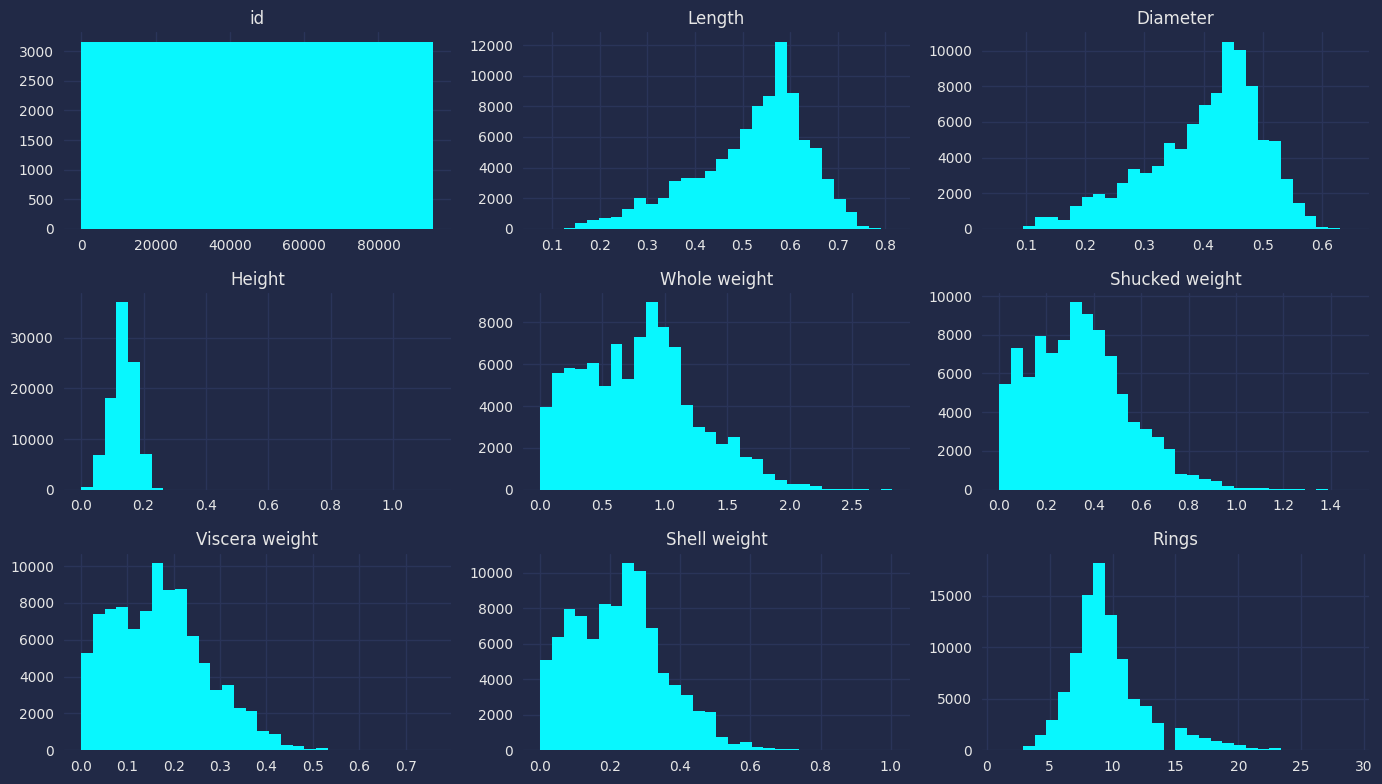

In [83]:
train.hist(figsize = (14,8), bins = 30)
plt.tight_layout()
plt.show()

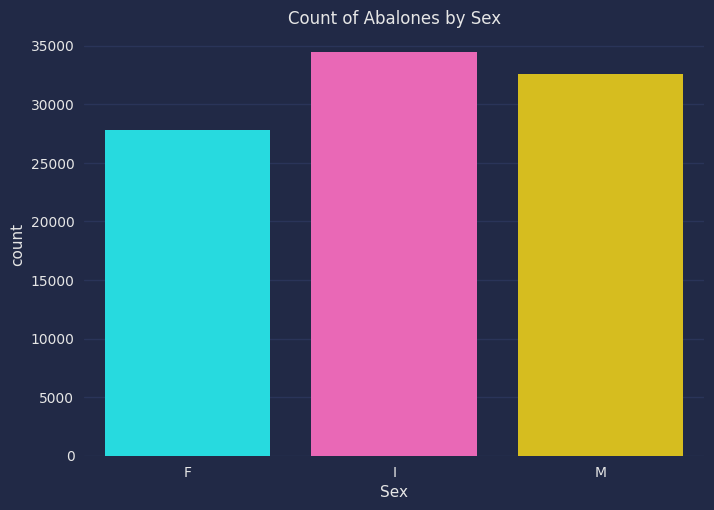

In [84]:
sns.countplot(x='Sex', data=train)
plt.title('Count of Abalones by Sex')
plt.show()

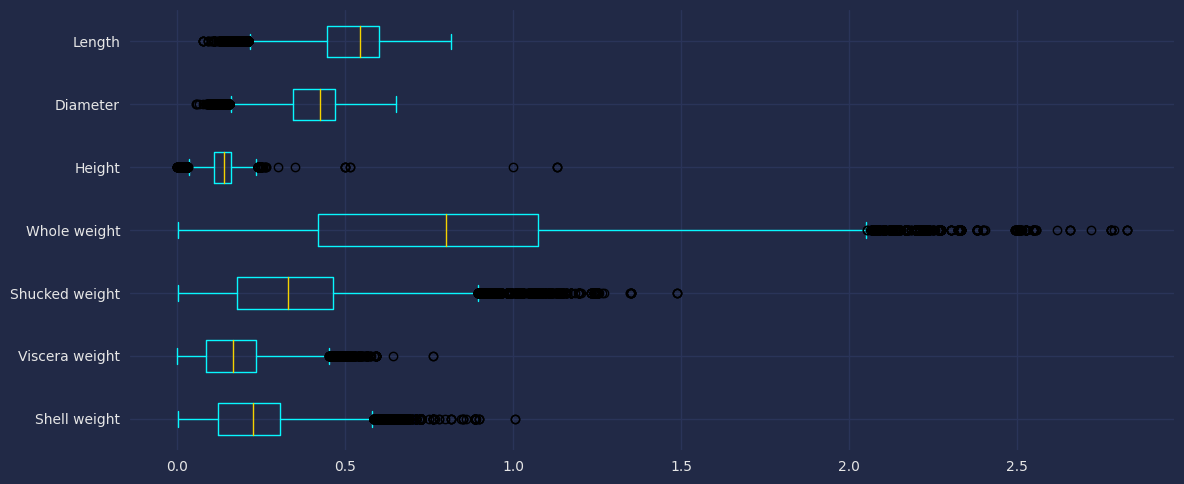

In [85]:
columns_reversed = train.drop(['id', 'Sex', 'Rings'], axis=1).columns[::-1]

train[columns_reversed].plot(kind='box', figsize=(12, 5), vert=False)
plt.tight_layout()
plt.show()

## Feature Engineering

In [86]:
def add_features(df):
    df = df.copy()
    
    df['Whole weight Ratio'] = df['Shucked weight']/df['Whole weight']
    df['Sex'] = df['Sex'].astype('category')
    
    return df

In [87]:
train2 = add_features(train)
test2 = add_features(test)

In [88]:
target = train2['Rings']
train2.drop(columns=['id','Rings','Sex'], inplace=True)
test2.drop(columns=['id','Rings','Sex'], inplace=True)

In [89]:
train2

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M,Whole weight Ratio
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,True,False,False,0.425794
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,True,False,False,0.405310
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,False,True,False,0.261905
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,False,False,True,0.410607
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,False,True,False,0.472506
...,...,...,...,...,...,...,...,...,...,...,...
94787,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,True,False,False,0.417136
94788,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,False,False,True,0.454451
94789,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,False,False,True,0.446854
94790,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,True,False,False,0.485153


In [90]:
from pycaret.regression import setup, compare_models

In [91]:
_ = setup(data=pd.concat([train2, target], axis = 1), target = 'Rings')

,Description,Value
0,Session id,6833
1,Target,Rings
2,Target type,Regression
3,Original data shape,"(94792, 12)"
4,Transformed data shape,"(94792, 12)"
5,Transformed train set shape,"(66354, 12)"
6,Transformed test set shape,"(28438, 12)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [92]:
model = compare_models(sort='RMSLE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.2490,3.4072,1.8457,0.6639,0.1507,0.1265,8.3030
lightgbm,Light Gradient Boosting Machine,1.2559,3.4440,1.8557,0.6602,0.1513,0.1271,0.8980
xgboost,Extreme Gradient Boosting,1.2656,3.5264,1.8777,0.6521,0.1527,0.1279,0.3800
gbr,Gradient Boosting Regressor,1.2768,3.5454,1.8828,0.6502,0.1532,0.1292,4.5050
rf,Random Forest Regressor,1.2927,3.5763,1.8910,0.6472,0.1554,0.1320,18.4600
et,Extra Trees Regressor,1.3026,3.6157,1.9014,0.6433,0.1562,0.1329,8.0720
huber,Huber Regressor,1.3565,4.1928,2.0474,0.5864,0.1641,0.1331,0.4940
br,Bayesian Ridge,1.3913,4.0670,2.0165,0.5988,0.1655,0.1413,0.0420
knn,K Neighbors Regressor,1.3712,4.1051,2.0260,0.5949,0.1655,0.1380,0.3650
lr,Linear Regression,1.3913,4.0670,2.0165,0.5988,0.1655,0.1413,0.5050


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

## HyperParamter Tuning

In [108]:
# import optuna
# import numpy as np
# import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
# from sklearn.model_selection import train_test_split

# # Define objective function for optimization
# def objective(trial):
#     # Define hyperparameters to be optimized
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
#         'random_strength': trial.suggest_loguniform('random_strength', 0.1, 10),
#         'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.1, 10),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
#     }

#     # Split the data
#     X_train, X_val, y_train, y_val = train_test_split(train2, target, test_size=0.2, random_state=42)

#     # Fit the CatBoost model
#     model = CatBoostRegressor(**params, verbose=False)
#     model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)

#     # Predict and calculate RMSLE
#     y_pred = model.predict(X_val)
#     rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))

#     return rmsle

# # Optimize hyperparameters using Optuna
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Get the best parameters
# best_params = study.best_params
# print("Best parameters:", best_params)

# # Train the model with the best parameters
# best_model = CatBoostRegressor(**best_params)
# best_model.fit(train2, target)

#### Catboost Regressor
- No log transformation
- Optuna HyperTuned
- Best RMSLE : 0.1497832158640954

Best parameters: {'iterations': 934, 'learning_rate': 0.05444261258765246, 'depth': 7, 'l2_leaf_reg': 2.635123463408289, 'random_strength': 1.5429959257899784, 'bagging_temperature': 1.20407627575537, 'border_count': 231, 'grow_policy': 'Depthwise'}


In [109]:
import lightgbm as lgb
import optuna
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_log_error

# # Load train dataset
# train_data = train2

# # Load target dataset
# target_data = target

# # Split data into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(train_data, target_data, test_size=0.2, random_state=42)

# # Define objective function for Optuna
# def objective(trial):
#     params = {
#         'objective': 'regression',
#         'metric': 'rmsle',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'num_iterations': trial.suggest_int('num_iterations', 50, 1000)
#     }

#     model = lgb.LGBMRegressor(**params)
#     model.fit(X_train, y_train)

#     preds = model.predict(X_val)
#     rmsle = np.sqrt(mean_squared_log_error(y_val, preds))
    
#     return rmsle

# # Create study object and optimize hyperparameters
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Get best parameters
# best_params = study.best_params
# print("Best Params:", best_params)

# # Train model with best parameters
# best_model = lgb.LGBMRegressor(**best_params)
# best_model.fit(X_train, y_train)

# # Predict
# predictions = best_model.predict(X_val)
# rmsle = np.sqrt(mean_squared_log_error(y_val, predictions))
# print("RMSLE on validation set:", rmsle)


#### LGBM
- No log transformation on target
- Optuna Hyperparameter Tuned
- Best RMSLE : 0.14965236297868925

{'lambda_l1': 0.0001165563455669194, 'lambda_l2': 4.681924963834088e-07, 'num_leaves': 113, 'feature_fraction': 0.43460388002303074, 'bagging_fraction': 0.9580391806195645, 'bagging_freq': 4, 'min_child_samples': 37, 'learning_rate': 0.021506924754963613, 'num_iterations': 777}.


In [110]:
target = np.log1p(target)

In [111]:
target

0        2.484907
1        2.484907
2        1.945910
3        2.397895
4        2.302585
           ...   
94787    2.484907
94788    2.397895
94789    2.302585
94790    2.397895
94791    2.564949
Name: Rings, Length: 94792, dtype: float64

#### CatBoost Regressor
- Optuna Hypertuned
- Target Transformation using np.log1p
- RMSLE Score : 0.04505285773684729

{'iterations': 646, 'learning_rate': 0.06757836128969, 'depth': 9, 'l2_leaf_reg': 4.415139544923779, 'random_strength': 1.0721412559148291, 'bagging_temperature': 1.5883147474959647, 'border_count': 255, 'grow_policy': 'Depthwise'}

#### LGBM
- Optuna Hypertuned
- Target Tranformation using np.log1p
- RMSLE score : 0.04490983813888798

{'lambda_l1': 0.7635285581632373, 'lambda_l2': 2.477035724490317, 'num_leaves': 85, 'feature_fraction': 0.45880960679526417, 'bagging_fraction': 0.9976769379507426, 'bagging_freq': 2, 'min_child_samples': 27, 'learning_rate': 0.039371368745000364, 'num_iterations': 774}


In [114]:
p1 = {'iterations': 934, 'learning_rate': 0.05444261258765246, 'depth': 7, 'l2_leaf_reg': 2.635123463408289, 'random_strength': 1.5429959257899784, 'bagging_temperature': 1.20407627575537, 'border_count': 231, 'grow_policy': 'Depthwise'}
p2 = {'lambda_l1': 0.0001165563455669194, 'lambda_l2': 4.681924963834088e-07, 'num_leaves': 113, 'feature_fraction': 0.43460388002303074, 'bagging_fraction': 0.9580391806195645, 'bagging_freq': 4, 'min_child_samples': 37, 'learning_rate': 0.021506924754963613, 'num_iterations': 777}
p3 = {'iterations': 646, 'learning_rate': 0.06757836128969, 'depth': 9, 'l2_leaf_reg': 4.415139544923779, 'random_strength': 1.0721412559148291, 'bagging_temperature': 1.5883147474959647, 'border_count': 255, 'grow_policy': 'Depthwise'}
p4 = {'lambda_l1': 0.7635285581632373, 'lambda_l2': 2.477035724490317, 'num_leaves': 85, 'feature_fraction': 0.45880960679526417, 'bagging_fraction': 0.9976769379507426, 'bagging_freq': 2, 'min_child_samples': 27, 'learning_rate': 0.039371368745000364, 'num_iterations': 774}

In [119]:
# target = np.expm1(target)
target_l = np.log1p(target)
target_l

0        2.484907
1        2.484907
2        1.945910
3        2.397895
4        2.302585
           ...   
94787    2.484907
94788    2.397895
94789    2.302585
94790    2.397895
94791    2.564949
Name: Rings, Length: 94792, dtype: float64

In [131]:
target

0        11.0
1        11.0
2         6.0
3        10.0
4         9.0
         ... 
94787    11.0
94788    10.0
94789     9.0
94790    10.0
94791    12.0
Name: Rings, Length: 94792, dtype: float64

In [121]:
model1 = CatBoostRegressor(**p1).fit(train2, target)
model2 = lgb.LGBMRegressor(**p2).fit(train2, target)
model3 = CatBoostRegressor(**p3).fit(train2, target_l)
model4 = lgb.LGBMRegressor(**p4).fit(train2, target_l)

0:	learn: 3.0765812	total: 27.5ms	remaining: 25.6s
1:	learn: 2.9817074	total: 54.1ms	remaining: 25.2s
2:	learn: 2.8932284	total: 81ms	remaining: 25.2s
3:	learn: 2.8103869	total: 108ms	remaining: 25.1s
4:	learn: 2.7352215	total: 134ms	remaining: 24.9s
5:	learn: 2.6649694	total: 161ms	remaining: 24.8s
6:	learn: 2.6010007	total: 187ms	remaining: 24.8s
7:	learn: 2.5420506	total: 214ms	remaining: 24.8s
8:	learn: 2.4876379	total: 242ms	remaining: 24.9s
9:	learn: 2.4364093	total: 269ms	remaining: 24.9s
10:	learn: 2.3904832	total: 298ms	remaining: 25s
11:	learn: 2.3479411	total: 325ms	remaining: 25s
12:	learn: 2.3090560	total: 352ms	remaining: 24.9s
13:	learn: 2.2732225	total: 379ms	remaining: 24.9s
14:	learn: 2.2404917	total: 407ms	remaining: 24.9s
15:	learn: 2.2108980	total: 434ms	remaining: 24.9s
16:	learn: 2.1836443	total: 466ms	remaining: 25.2s
17:	learn: 2.1579901	total: 501ms	remaining: 25.5s
18:	learn: 2.1338232	total: 529ms	remaining: 25.5s
19:	learn: 2.1128460	total: 557ms	remaining:

In [138]:
def rmsle_score(model, train_data, target):

    predictions = model.predict(train_data)
    print(predictions)
    msle = mean_squared_log_error(target, predictions)
    rmsle = np.sqrt(msle)
    
    print(rmsle)

def rmsle_score_l(model, train_data, target):
    
    predictions = np.expm1(model.predict(train_data))
    print(predictions)
    msle = mean_squared_log_error(target, predictions)
    rmsle = np.sqrt(msle)
    
    print(rmsle)

In [141]:
rmsle_score(model1, train2, target)

[10.20077251 10.33421459  4.12628521 ... 10.47653282  9.00797727
 11.74997634]
0.1330071197623117


In [142]:
rmsle_score(model2, train2, target)

[LightGBM] [Warning] feature_fraction is set=0.43460388002303074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43460388002303074
[LightGBM] [Warning] lambda_l2 is set=4.681924963834088e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.681924963834088e-07
[LightGBM] [Warning] lambda_l1 is set=0.0001165563455669194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001165563455669194
[LightGBM] [Warning] bagging_fraction is set=0.9580391806195645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9580391806195645
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[10.17731748 10.57951833  4.13171047 ... 10.55629388  8.88629051
 12.23428674]
0.1359849792457029


In [135]:
rmsle_score_l(model3, train2, target_l)

[10.19089676 10.40331472  4.48333862 ... 10.12216578  8.97529918
 11.88787304]
1.1438070963578524


In [137]:
rmsle_score_l(model4, train2, target_l)

[LightGBM] [Warning] feature_fraction is set=0.45880960679526417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45880960679526417
[LightGBM] [Warning] lambda_l2 is set=2.477035724490317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.477035724490317
[LightGBM] [Warning] lambda_l1 is set=0.7635285581632373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7635285581632373
[LightGBM] [Warning] bagging_fraction is set=0.9976769379507426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9976769379507426
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[10.09180053 10.46636754  4.07163815 ... 10.6231915   8.7767459
 11.92520042]
1.1438995189630214


In [146]:
predictions1 = model1.predict(test2)
predictions2 = model2.predict(test2)

[LightGBM] [Warning] feature_fraction is set=0.43460388002303074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43460388002303074
[LightGBM] [Warning] lambda_l2 is set=4.681924963834088e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.681924963834088e-07
[LightGBM] [Warning] lambda_l1 is set=0.0001165563455669194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001165563455669194
[LightGBM] [Warning] bagging_fraction is set=0.9580391806195645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9580391806195645
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [176]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e4/sample_submission.csv')
submission.to_csv("sample", header=True, index=False)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_33/2761056047.py", line 3, in <module>
    submission.to_csv("sample", header=True, index=False)
  File "/opt/conda/lib/python3.10/site-packages/pandas/util/_decorators.py", line 333, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/pandas/core/generic.py", line 3964, in to_csv
    """
  File "/opt/conda/lib/python3.10/site-packages/pandas/io/formats/format.py", line 995, in to_csv
  File "/opt/conda/lib/python3.10/site-packages/pandas/io/formats/csvs.py", line 96, in __init__
    self.cols = self._initialize_columns(cols)
  File "/opt/conda/lib/python3.10/site-packages/pandas/io/formats/csvs.py", line 168, in _initialize_columns
    return new_cols._format_native_types(**self._number_format)
AttributeError: 'Index' object has no

In [168]:
submission['Rings'] = predictions1
submission.head()

,id,Rings
0,90615,9.748180
1,90616,9.733511
2,90617,9.988635
3,90618,10.525193
4,90619,7.624202


In [173]:
submission.reset_index(drop=True, inplace=True)  # Reset index without adding it as a column
submission.to_csv("Submission2.csv", index=False)  # Save without the index


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_33/2208188668.py", line 2, in <module>
    submission.to_csv("Submission2.csv", index=False)  # Save without the index
  File "/opt/conda/lib/python3.10/site-packages/pandas/util/_decorators.py", line 333, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/pandas/core/generic.py", line 3964, in to_csv
    """
  File "/opt/conda/lib/python3.10/site-packages/pandas/io/formats/format.py", line 995, in to_csv
  File "/opt/conda/lib/python3.10/site-packages/pandas/io/formats/csvs.py", line 96, in __init__
    self.cols = self._initialize_columns(cols)
  File "/opt/conda/lib/python3.10/site-packages/pandas/io/formats/csvs.py", line 168, in _initialize_columns
    return new_cols._format_native_types(**self._number_format)
AttributeError: